# Spam Comments Detection

## Tahap 1: Data Preparation and Data Cleaning
------------------------------------------------

##### **Daftar Isi pada Notebook**
1. Background - Latar belakang pembuatan projek dan sumber data yang digunakan hingga tujuan penelitian
2. Notebook Setup - mengimport package dan data
3. Overview data
5. Data Cleaning
   - lowercase
   - remove punctuation 
   - remove white spaces
6. Feature Extraction
    - url_ratio
    - urlcount
    - Number of white spce
    - word duplicate ratio
    - count emoji
    - stpopword ratio
    - count non ascii letter
    - count upper letters
7. Export data yang telah dilakukan prepocessing kedalam format .csv

------------------------------------------------------

**1. Background**

**Latar Belakang Project**



**Tujuan Project**
Pada project kali ini pendeteksian komentar spam dilakukan untuk menemukan komentar yang tidak relevan berisikan "promosi" sehingga hasilnya dapat digunakan untuk mengetahui sebuah komentar yang relevan dengan konten videonya. 


---------------------------------------------------

**Sumber Data**

Data yang digunakan berasal dari YouTube dengan melakukan crawling data menggunakan YouTube Data API. Mengekstrak dataset berdasarkan query yang telah dipilih, kemudian untuk memperoleh komentar dengan videoId menggunakan videoId.

Metadata yang dipilih anatara lain:
- videoId
- Tittle Video
- Name (username)
- Commment
- CommentId
- Time
- Like
- Reply Count
- Label

---------------------------------------------------

**Notebook Setup**

In [1]:
import pandas as pd
import glob
import os
import regex as re
import emoji
import pandas as pd
import numpy as np
import time
import string
from string import punctuation
import seaborn as sns
import emoji
from unidecode import unidecode
#from nltk.tokenize import word_tokenize
import datetime
from nltk.util import ngrams
from collections import Counter
from tokenize import group
import sys
import textdistance
import pycrfsuite
import tweepy
import nltk
import pandas as pd
from pandas import json_normalize
import pickle
import collections
import math
import urllib
import nltk
from nltk.corpus import stopwords
from difflib import SequenceMatcher
import spacy
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
from textblob import TextBlob
#import pycrfsuite
from tokenize import group
#from nltk.tag import CRFTagger
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from spacy.lang.id import Indonesian
#from spacy.lang.id.stop_words import STOP_WORDS
import warnings; warnings.simplefilter('ignore')

[nltk_data] Downloading package punkt to C:\Users\asus.LAPTOP-
[nltk_data]     EVKQ06QK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\asus.LAPTOP-
[nltk_data]     EVKQ06QK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("..\Data\Data Label\LabelData.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002 entries, 0 to 3001
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Video_Id     3002 non-null   object 
 1   Tittle       3002 non-null   object 
 2   Description  3002 non-null   object 
 3   Name         3002 non-null   object 
 4   Comment      3002 non-null   object 
 5   Comment_Id   3002 non-null   object 
 6   Time         3002 non-null   object 
 7   Likes        3002 non-null   int64  
 8   Reply_Count  2623 non-null   float64
 9   Label        3002 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 234.7+ KB


In [3]:
df["Label"] = df["Label"].astype("category")
df["Time"] = df["Time"].astype("datetime64")

In [4]:
df.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label
125,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Nur Vica Komalasari,Mampir ya gaisss https://youtu.be/Sy2XOe7sP3Q,Ugw8jgJznWTuQ0Rkvad4AaABAg,2019-04-10 02:24:30,0,0.0,spam


In [5]:
data = df.drop_duplicates(subset=["Name","Comment","Time"], keep=False)
#Parameter pada drop duplicates defaultnya first
#    - First: drop duplikat kecuali untuk kemunculan pertama.  
#    - Last: drop duplikat kecuali untuk kejadian terakhir.
#    - False : drop semua duplikat

In [6]:
B, K = data.shape
print(f"Banyaknya Saat ini adalah Baris: {B} dan Kolom: {K}")

Banyaknya Saat ini adalah Baris: 3000 dan Kolom: 10


In [7]:
data.isnull().sum()

Video_Id         0
Tittle           0
Description      0
Name             0
Comment          0
Comment_Id       0
Time             0
Likes            0
Reply_Count    379
Label            0
dtype: int64

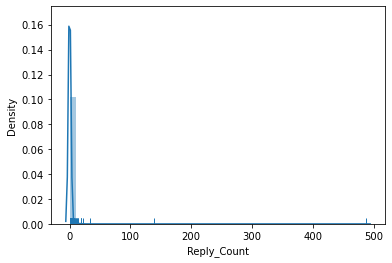

In [8]:
p = sns.distplot(data['Reply_Count'], kde=True, rug=True)

In [9]:
data['Reply_Count'].fillna(data['Reply_Count'].median(),inplace=True)

In [10]:
data.isnull().sum()

Video_Id       0
Tittle         0
Description    0
Name           0
Comment        0
Comment_Id     0
Time           0
Likes          0
Reply_Count    0
Label          0
dtype: int64

In [11]:
data["Reply_Count"] = data["Reply_Count"].astype("int64")

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 3001
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Video_Id     3000 non-null   object        
 1   Tittle       3000 non-null   object        
 2   Description  3000 non-null   object        
 3   Name         3000 non-null   object        
 4   Comment      3000 non-null   object        
 5   Comment_Id   3000 non-null   object        
 6   Time         3000 non-null   datetime64[ns]
 7   Likes        3000 non-null   int64         
 8   Reply_Count  3000 non-null   int64         
 9   Label        3000 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(2), object(6)
memory usage: 237.4+ KB


In [20]:
data.to_csv("..\Data\Assets\ForEDA.csv", index=False)

## **ToyData**

**toyData** dibuat untuk mempermudah hasil proses cleaning maupun feature extraction yang sedang dicoba serta bertujuan sebagai sample data yang akan ditampilkan pada hasil seminar hasil dan sidang skripsi.

### Cleaning Text

In [13]:
toyData = pd.read_csv("../Data/Comments/toyData.csv")

In [16]:
B, K = toyData.shape
print(f"Banyaknya data saat ini adalah Baris: {B} dan Kolom: {K}")

Banyaknya data saat ini adalah Baris: 10 dan Kolom: 10


In [15]:
toyData.isnull().sum()

Video_Id       0
Tittle         0
Description    0
Name           0
Comment        0
Comment_Id     0
Time           0
Likes          0
Reply_Count    1
Label          0
dtype: int64

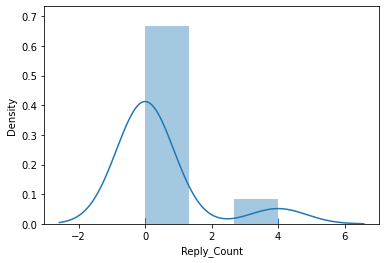

In [17]:
p = sns.distplot(toyData['Reply_Count'], kde=True, rug=True)

In [18]:
toyData['Reply_Count'].fillna(toyData['Reply_Count'].median(),inplace=True)

In [19]:
toyData.isnull().sum()

Video_Id       0
Tittle         0
Description    0
Name           0
Comment        0
Comment_Id     0
Time           0
Likes          0
Reply_Count    0
Label          0
dtype: int64

In [2]:
#NLTK_StopWords = stopwords.words('english')
factory = StopWordRemoverFactory()
Sastrawi_StopWords_id = factory.get_stop_words()

In [21]:
def lower(text):
    text = text.lower()
    return text

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def remove_emoji(text):
    pattern = emoji.get_emoji_regexp()
    without_emoji = pattern.sub('', text)
    return without_emoji

#def replace_url(text, replacement):
    text = str(text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    text = re.sub('[/]?watch(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    return text

'''Detect link and replace with url'''
urlregex = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")

def detecturl(text):
    url_filtered_comment = re.sub(urlregex, ' ',text)
    return url_filtered_comment

def url(text):
    punc_table = {ord(c): None for c in punctuation}
    text ="".join(t if i % 2 else t.translate(punc_table) for (i, t) in enumerate(urlregex.split(text)))
    return text

def remove_punc_except_urls(s, punctuationRegex=r'#[^.?!,a-zA-Z0-9\.]'): #[^.,a-zA-Z0-9\n\.] #^a-zA-Z0-9\s
  # arrays to keep track of indices
  urlInds = []
  puncInds = []
  # find all the urls
  for m in re.finditer(r'(https?|ftp)://[^\s/$.?#].[^\s]*', s):
    urlInds.append((m.start(0), m.end(0)))
  # find all the punctuation
  for m in re.finditer(punctuationRegex, s):
    puncInds.append((m.start(0), m.end(0)))
  # start removing punctuation from end so that indices do not change
  puncInds.reverse()
  # go through each of the punctuation indices and remove the character if it is not inside a url
  for puncRange in puncInds:
    inUrl = False
    # check each url to see if this character is in it
    for urlRange in urlInds:
      if puncRange[0] >= urlRange[0] and puncRange[0] <= urlRange[1]:
        inUrl = True
        break
    if not inUrl:
      # remove the punctuation from the string
      s = s[:puncRange[0]] + s[puncRange[1]:]
  return s


#def detecturl(text, replace):
#    url_filtered_comment = re.sub(urlregex, replace,text)
#    return url_filtered_comment

'''hastags'''
#def fixTags(T):
#    getHashtags = re.compile(r"#(\w+)")
#    pisahtags = re.compile(r'[A-Z][^A-Z]*')
#    t = T
#    tagS = re.findall(getHashtags, T)
#    for tag in tagS:
#        proper_words = ' '.join(re.findall(pisahtags, tagS[0]))
#        t = t.replace('#' + tag, proper_words)
#    return t

#def getTags(T):
#    getHashtags = re.compile(r"#(\w+)")
#    tagS = re.findall(getHashtags, T)
    #isitag = []
    #for tag in tagS:       
    #    tag = '#'+tag
    #    isitag.append(tag)
    
#    return ', '.join(isitag)

'''remove punctuation'''
clean_spcl = re.compile('[/(){}\[\]\|!;$]')
clean_symbol = re.compile('[^.,a-zA-Z0-9\.]')
simbol = re.compile(r'#(^\w)')

def clean_punct(text):
    text = clean_spcl.sub(' ', text)
    #text = clean_symbol.sub(' ', text)
    return text

def hastag(text):   
    text = simbol.sub('', text)
    return text

def clean_symbols(text): #this function remove the #
    text = clean_symbol.sub(' ', text)
    return text

'''white_spaces'''
def white_spaces(text):
    single_char_pattern = re.compile(r'\s+')
    text = re.sub(pattern=single_char_pattern, repl=' ', string=text)
    return text

'''Stopwords Sastrawi'''
stopwords = set(Sastrawi_StopWords_id)

def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopwords) # hapus stopword dari kolom deskripsi
    return text

def en_stopwords(text):
    df=open('..\Stopwords_eng\stopwords_en.txt',"r",encoding="utf-8", errors='replace')
    en_stop = df.readlines()
    df.close()
    en_stop = [t.strip().lower() for t in en_stop]
    en_stop = set(en_stop)
    text = ' '.join(word for word in text.split() if word not in en_stop) # hapus stopword dari kolom deskripsi
    return text
    
def id_stopwords(text):
    df=open('..\Stopwords\stopwords.txt',"r",encoding="utf-8", errors='replace')
    id_stop = df.readlines()
    df.close()
    id_stop = [t.strip().lower() for t in id_stop]
    id_stop = set(id_stop)
    text = ' '.join(word for word in text.split() if word not in id_stop) # hapus stopword dari kolom deskripsi
    return text

'''Slangwords'''
def slang(text):
    df=open('../Slangwords/slangwords.txt',"r",encoding="utf-8", errors='replace')
    slangS = df.readlines()
    slangS = [t.split(":") for t in slangS]
    slangS = [[k.strip(), v.strip()] for k,v in slangS]
    slangS = {k:v for k,v in slangS}

    T = TextBlob(text).words
    
    for i,t in enumerate(T):
        if t in slangS.keys():
            T[i] = slangS[t]
        
    T =' '.join(T)

    return T

**Cleaning 1**

Cleaning Data tanpa menggunakan stopwords

In [3]:
urlregex = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
punctuation = list(string.punctuation)
punctuation.remove("#")
punctuation.remove("@") #bcs in commentar field sometimes user share/promote their username
punctuation.remove("_") #bcs username instagram using underscore
punctuation.append("•")

def cleaning(text):
    text = text.lower()
    punc_table = {ord(c): None for c in punctuation}
    text ="".join(t if i % 2 else t.translate(punc_table) for (i, t) in enumerate(urlregex.split(text)))
    pattern = re.compile(r'\s+')
    text = re.sub(pattern=pattern, repl=' ', string=text)
    return text


**Cleaning 2**

Cleaning data dengan menggunakan stopwords

In [23]:
stopwords = set(Sastrawi_StopWords_id)

def cleaning_with_stopwords(text):
    text = text.lower()
    punc_table = {ord(c): None for c in punctuation}
    text ="".join(t if i%2 else t.translate(string.punctuation) for (i, t) in enumerate(urlregex.split(text)))
    pattern = re.compile(r'\s+')
    text = re.sub(pattern=pattern, repl=' ', string=text)
    text = ' '.join(word for word in text.split() if word not in stopwords) # hapus stopword dari kolom deskripsi
    return text

---------------------------------------------------------------------

***trial code***

In [4]:
punctuation

['!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '[',
 '\\',
 ']',
 '^',
 '`',
 '{',
 '|',
 '}',
 '~',
 '•']

In [28]:
text = toyData["Comment"][2]

In [29]:
text = "follow instagram aku""ya @dewirizki__                                https://youtu.be/cZkyOfhoMF8 versi 2"

In [30]:
cleaning_with_stopwords(text)

'follow instagram akuya @dewirizki__ https://youtu.be/czkyofhomf8 versi 2'

-----------------------------------------------

#### **Cleaned_Comment Toy Data**

***for toyData*** dengan menggunakan **cleaning 1 (tanpa stopword)**

Pada proses cleaning comment pertama **melakukan** beberapa hal antara lain:
- lowercase string
- remove punctuation dengan pengecualian # dan @ karena ini bergantung dengan user on youtube yang mempromosikan username sosial medianya di kolom komentar

In [24]:
toyData["cleanTitle"] = toyData["Tittle"].apply(lambda x: cleaning(x))

In [25]:
toyData['cleanedComment'] = toyData['Comment'].apply(lambda x: cleaning(x))
toyData['cleanedDesc'] = toyData['Description'].apply(lambda x: cleaning(x))

In [26]:
toyData

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,cleanTitle,cleanedComment,cleanedDesc
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17T23:06:24Z,0,0.0,spam,panas jokowi vs prabowo saling serang soal kor...,https://youtu.be/lbkgyxnpmcu,debat panas antara kedua pasangan calon presid...
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,GUGUS NTB_Si Luh Putu Sri Utari,Om Swastyastu🙏\nHari Kartini sudah dekat! Dala...,UgzbWRmjT5OKeSSBtaN4AaABAg,2019-04-18T01:15:38Z,29,4.0,spam,skinnyindonesian24 prabowo vs jokowi epic rap ...,om swastyastu🙏 hari kartini sudah dekat dalam ...,skinnyindonesian24 andovi da lopez sebagai jok...
2,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,MBAH SEMAR OFFICIAL,https://youtu.be/AX-l8ZYTjhA,UgyOsI2ZNgcGjq_pget4AaABAg,2019-02-19T12:13:00Z,0,0.0,spam,full live debat kedua capres pemilu 2019 jokow...,https://youtu.be/ax-l8zytjha,tanpa jeda iklan tonton lagi full live debat k...
3,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,Bakol Daster,Surat an-nazi'at hapalan anak2\nhttps://youtu....,UgxUlmW4iEMQSjwVbxB4AaABAg,2019-02-19T11:47:37Z,0,0.0,spam,full live debat kedua capres pemilu 2019 jokow...,surat annaziat hapalan anak2 https://youtu.be/...,tanpa jeda iklan tonton lagi full live debat k...
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,REDHADITYA RADJAB,REAL TESTIMONI\n•\n•\nNEW NORMAL harus punya m...,UgypCpHwp6aAVFptegd4AaABAg,2020-08-09T06:50:48Z,0,0.0,spam,skinnyindonesian24 prabowo vs jokowi epic rap ...,real testimoni new normal harus punya muka ber...,skinnyindonesian24 andovi da lopez sebagai jok...
5,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teddy Taufani,"Siapa yg merinding nonton ini video, like 😨",UgymWIjnqV3Z9JOVGkV4AaABAg,2019-04-10T08:49:44Z,1,0.0,legitimate,skinnyindonesian24 prabowo vs jokowi epic rap ...,siapa yg merinding nonton ini video like 😨,skinnyindonesian24 andovi da lopez sebagai jok...
6,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Riska Amalia,Ngak tahu kah kabarnya papua juga merasa diboh...,UgzStrrzMVkeANhiC414AaABAg.8qD2VVBYdUu8qWQTAlgely,2019-01-25T05:19:29Z,0,0.0,legitimate,panas jokowi vs prabowo saling serang soal kor...,ngak tahu kah kabarnya papua juga merasa diboh...,debat panas antara kedua pasangan calon presid...
7,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,Iputh channelh,siapaun yang menjadi pemimpin kedepannya kami ...,UgyFQM13K061MRW5ePV4AaABAg,2019-02-22T07:29:37Z,0,0.0,legitimate,full live debat kedua capres pemilu 2019 jokow...,siapaun yang menjadi pemimpin kedepannya kami ...,tanpa jeda iklan tonton lagi full live debat k...
8,LU2p56QVUWA,Debat Jokowi Vs Prabowo Soal Ideologi &amp; Pe...,DebatCapres #DebatJokowiPrabowo #DebatKeempatC...,Tokoku5. id,Pokok e pak JOKOWI 2 periode 👍👍 \nkalau prabo...,Ugybh8aHiCkeMLnDzMZ4AaABAg,2019-03-31T08:25:32Z,2,0.0,legitimate,debat jokowi vs prabowo soal ideologi amp peme...,pokok e pak jokowi 2 periode 👍👍 kalau prabowo ...,debatcapres #debatjokowiprabowo #debatkeempatc...
9,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09T04:08:18Z,0,0.0,legitimate,skinnyindonesian24 prabowo vs jokowi epic rap ...,👆👆👆👆👆👆,skinnyindonesian24 andovi da lopez sebagai jok...


In [27]:
toyData.to_csv("..\Data\Assets\ToyData\CleaningToy.csv")

In [58]:
toyData['cleanedComment'] = toyData['Comment'].apply(lambda x: cleaning_with_stopwords(x))

In [59]:
toyData.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,LengthComment,cleanTitle,cleanedComment,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters
6,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Prananda Putra,https://youtu.be/KqYVS_WhNkc,UgzMjSSFIJMpepi-Gqp4AaABAg,2019-04-11 09:33:10,0,0,spam,1,skinnyindonesian24 prabowo vs jokowi epic rap ...,https://youtu.be/kqyvs_whnkc,1,0,0.0,1.0,0,0,6


## Feature Engineering

**Feature Engineering on Youtube**

In [28]:
#count comments words length
def count_words(text):
    return len(text.split())


#url_ratio
def url_ratio(text):
    #pattern =(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
    urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    #urls = re.findall(pattern=pattern, string=text)
    url_char = 0
    for url in urls:
        url_char += len(url)
    return url_char/len(text)

#count url
def count_url(text):
    #pattern =(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
    urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    #urls = re.findall(pattern=pattern, string=text)
    return len(urls)

#count white space
def count_extra_white_spaces(text):
    single_char_pattern = r'\s+'
    without_sc = re.findall(pattern=single_char_pattern, string=text)
    return len(without_sc)

def word_duplicate_ratio(text):
    try:
        text = unidecode(text)
        unique_words = set()
        word = []
        for i in text:
            for d in text.split():      
                unique_words.add(d)
                word.append(d)
        td =len(word)
        return(len(unique_words)/td)
    except:
        if len(word) == 0:
            return 0

#word_duplicate_ratio
def duplicate_ratio(text):
    try:
        text = unidecode(text)
        word = Counter(text.split())
        wordList = [k for k, v in word.items()]
        countWords =[j for j in word.values()]
        return (len(wordList)/sum(countWords))
    except:
        return 0

#def count_punctuation((text),(string.punctuation)):
#    count = lambda l1,l2: sum([1 for text in l1 if text in l2])
#    return count
    #df['count_punct'] = df.content.apply(lambda s: count(s, string.punctuation))
#def stopwords_ratio()

#non_ascii
def non_ascii(text): #emoticon count as ascii characters
    pattern = (r'[^\x00-\x7f]')
    non_ascii_count = re.findall(pattern=pattern, string=text)
    return len(non_ascii_count)

#upper letters
def upper_letters(text):
    sum_upper_letters = sum(map(str.isupper, text))
    return sum_upper_letters

#count emoji
def count_emoji(text):
    emoji_list = []
    data = re.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    return len(emoji_list)

#stopwords ratio
stopwords = set(Sastrawi_StopWords_id)
def stopword_ratio(text):
    try:
        stopword = set(list(word for word in text.split() if word in stopwords))
        word = [word for word in text.split()]
        return len(stopword)/len(word)
    except:
        return 0

#similarity
def similarity(text, post):
    text = unidecode(text)
    words=[word for word in text.split(" ")]

    post = unidecode(post)
    post = [word for word in post.split(" ")]

    words_doc1 = set(words) 
    words_doc2 = set(post)

    intersection = words_doc1.intersection(words_doc2)
    return (len(intersection)) / (1 + abs(len(words) - len(post)))

#length sentence
def LengthSentence(text):
    blob_object = TextBlob(text)
    corpus_sentence = blob_object.sentences
    # To identify all tokens
    # To count the number of tokens
    return(len(corpus_sentence))

**Feature Engineering on Twitter**

In [11]:
from nltk.tag import CRFTagger
ct = CRFTagger()

In [12]:
ct.set_model_file('../Assets/all_indo_man_tag_corpus_model.crf.tagger')

In [17]:
nlp = spacy.blank('id')
# CommentLen
def Comment_len(text):
    try:
        return len(text)
    except:
        return 0

# UserNameLen
def name_len(text):
    try: 
        return len(text)
    except:
        return 0


# LexRichWithUU
def lex_richness(text):
    try:
        tokens = nlp(text)
        tokens = [str(t) for t in tokens]
        ut = set(tokens)
        return (len(ut)/float(len(tokens)))*100
    except:
        return 0
    
urlregex = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
punctuation.append("#")
# LexRichWithOutUU
def lex_density(text):
    try:
        punc_table = {ord(c): None for c in punctuation}
        text ="".join(t if i % 2 else t.translate(punc_table) for (i, t) in enumerate(urlregex.split(text)))
        hasil = ct.tag_sents([text.split()])
        pos = set(['NN', 'JJ', 'VB', 'RB'])
        lex_word = []
        for i in hasil[0]:
            if i[1] in pos:
                lex_word.append(i[0])
        return (len(lex_word)/len(hasil[0]))*100
    except:
        return 0

# CommentRandomness
def Comment_randomness(text):
    try:
        text_len = len(text)
        bases = collections.Counter([i for i in text])

        shannon_entropy_value = 0
        for base in bases:
            n_i = bases[base]
            p_i = n_i / float(text_len)
            entropy_i = p_i * (math.log(p_i, 2))
            shannon_entropy_value += entropy_i
        return (shannon_entropy_value * -1)/text_len
    except:
        return 0

# UserNameRandomness
def name_randomness(text):
    try:
        text_len = len(text)
        bases = collections.Counter([i for i in text])

        shannon_entropy_value = 0
        for base in bases:
            n_i = bases[base]
            p_i = n_i / float(text_len)
            entropy_i = p_i * (math.log(p_i, 2))
            shannon_entropy_value += entropy_i
        return (shannon_entropy_value * -1)/text_len
    except:
        return 0

-----

***trial code***

In [6]:
punctuation

['!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '[',
 '\\',
 ']',
 '^',
 '`',
 '{',
 '|',
 '}',
 '~',
 '•',
 '#']

In [18]:
lex_density("#janganlupa makan #trending #jinyoung yumi celss")

janganlupa makan trending jinyoung yumi celss
[[('janganlupa', 'SC'), ('makan', 'VB'), ('trending', 'NN'), ('jinyoung', 'VB'), ('yumi', 'NN'), ('celss', 'FW')]]
['makan', 'trending', 'jinyoung', 'yumi']


66.66666666666666

In [4]:
Comment_len("aku suka makan mie")

18

In [11]:
count_words("aku suka makan mie dan aku suka makan pisang")

9

![Similarity](../Image/Post-Comment%20Similarity.png "PostComment Similairity")

In order to compare the effectiveness of inter-comment similairty with features such as post-comment similarity, dengan menghitung post-comment similarity sama dengan inter-comment similarity yaitu dengan menggunakan *koefisien Jaccard dan Dice's* pada *n-gram*

In [52]:
def Jaccard_Similarity(text, post, ngram=1):
    text = unidecode(text)
    words=[word for word in text.split(" ") if word not in stopwords]  
    #print("Sentence after removing stopwords:",words)
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]

    post = unidecode(post)
    post = [word for word in post.split(" ") if word not in stopwords]  
    #print("Sentence after removing stopwords:",words)
    temp=zip(*[post[i:] for i in range(0,ngram)])
    post = [' '.join(ngram) for ngram in temp]
    
    # List the unique words in a document
    words_doc1 = set(ans) 
    #print(words_doc1)
    words_doc2 = set(post)
    #print(words_doc2)
    
    # Find the intersection of words list of doc1 & doc2
    intersection = words_doc1.intersection(words_doc2)

    # Find the union of words list of doc1 & doc2
    union = words_doc1.union(words_doc2)
        
    # Calculate Jaccard similarity score 
    # using length of intersection set divided by length of union set
    return float(len(intersection)) / len(union)

In [43]:
Jaccard_Similarity('jokowi vs prabowo', "apakah jokowi makan nasi")

{'jokowi', 'prabowo', 'vs'}
{'jokowi', 'makan', 'nasi'}


0.2

In [88]:
text = unidecode(text)
word = Counter(text.split())
print(word)
wordList = [k for k, v in word.items()]
print(wordList)
print(len(wordList))
countWords =[j for j in word.values()]
countWords = sum(countWords)
print(countWords)
print(len(wordList)/countWords)

Counter({'keren,tapi': 1, 'ini': 1, 'lebih': 1, 'keren': 1, ':': 1, 'https://www.youtube.com/watch?v=qymh2pk6hdu': 1})
['keren,tapi', 'ini', 'lebih', 'keren', ':', 'https://www.youtube.com/watch?v=qymh2pk6hdu']
6
6
1.0


In [62]:
def LengthSentence(text):
    blob_object = TextBlob(text)
    corpus_sentence = blob_object.sentences
    # To identify all tokens
    # To count the number of tokens
    return(len(corpus_sentence))

In [12]:
LengthSentence("panas jokowi VS prabowo saling serang soal. jokowi mama")

2

In [128]:
unique_words = set()
word = []
for d in text.split():      
    unique_words.add(d)
    word.append(d)
td =len(word)
print(len(unique_words))
print(td)
print(len(unique_words)/td)

4
5
0.8


----

In [32]:
toyData['countUrl'] = toyData['Comment'].apply(lambda x: count_url(x))
toyData['CommentLength'] = toyData["cleanedComment"].apply(lambda x: count_words(x) )
toyData['LengthSentence'] = toyData['Comment'].apply(lambda x: LengthSentence(x))
toyData['WhiteSpacenum'] = toyData['Comment'].apply(lambda x: count_extra_white_spaces(x))
toyData['StopwordRatio'] = toyData['cleanedComment'].apply(lambda x: stopword_ratio(x))
toyData['WorldDuplicateRatio'] = toyData['cleanedComment'].apply(lambda x: duplicate_ratio(x))
toyData['CountEmoji'] = toyData['cleanedComment'].apply(lambda x: count_emoji(x))
toyData['CountNonAscii'] = toyData['cleanedComment'].apply(lambda x: non_ascii(x))
toyData['CountUpperLetters'] = toyData['Comment'].apply(lambda x: upper_letters(x))
toyData['SimilarityTitle'] = toyData.apply(lambda x: similarity(x.cleanedComment, x.cleanTitle), axis=1)
toyData['SimilarityDesc'] = toyData.apply(lambda x: similarity(x.cleanedComment, x.cleanedDesc), axis=1)

In [33]:
toyData

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,CommentLength,LengthSentence,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17T23:06:24Z,0,0.0,spam,...,1,1,0,0.000000,1.000000,0,0,7,0.000000,0.000000
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,GUGUS NTB_Si Luh Putu Sri Utari,Om Swastyastu🙏\nHari Kartini sudah dekat! Dala...,UgzbWRmjT5OKeSSBtaN4AaABAg,2019-04-18T01:15:38Z,29,4.0,spam,...,49,5,48,0.142857,0.708333,5,5,16,0.000000,0.060606
2,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,MBAH SEMAR OFFICIAL,https://youtu.be/AX-l8ZYTjhA,UgyOsI2ZNgcGjq_pget4AaABAg,2019-02-19T12:13:00Z,0,0.0,spam,...,1,1,0,0.000000,1.000000,0,0,6,0.000000,0.000000
3,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,Bakol Daster,Surat an-nazi'at hapalan anak2\nhttps://youtu....,UgxUlmW4iEMQSjwVbxB4AaABAg,2019-02-19T11:47:37Z,0,0.0,spam,...,9,1,8,0.000000,1.000000,0,0,7,0.000000,0.000000
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,REDHADITYA RADJAB,REAL TESTIMONI\n•\n•\nNEW NORMAL harus punya m...,UgypCpHwp6aAVFptegd4AaABAg,2020-08-09T06:50:48Z,0,0.0,spam,...,318,3,319,0.075472,0.664495,11,20,111,0.000000,0.013245
5,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teddy Taufani,"Siapa yg merinding nonton ini video, like 😨",UgymWIjnqV3Z9JOVGkV4AaABAg,2019-04-10T08:49:44Z,1,0.0,legitimate,...,8,1,7,0.125000,1.000000,1,1,1,0.000000,0.200000
6,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Riska Amalia,Ngak tahu kah kabarnya papua juga merasa diboh...,UgzStrrzMVkeANhiC414AaABAg.8qD2VVBYdUu8qWQTAlgely,2019-01-25T05:19:29Z,0,0.0,legitimate,...,24,1,26,0.291667,0.958333,0,0,1,0.000000,0.125000
7,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,Iputh channelh,siapaun yang menjadi pemimpin kedepannya kami ...,UgyFQM13K061MRW5ePV4AaABAg,2019-02-22T07:29:37Z,0,0.0,legitimate,...,16,1,15,0.250000,1.000000,0,0,0,0.000000,0.000000
8,LU2p56QVUWA,Debat Jokowi Vs Prabowo Soal Ideologi &amp; Pe...,DebatCapres #DebatJokowiPrabowo #DebatKeempatC...,Tokoku5. id,Pokok e pak JOKOWI 2 periode 👍👍 \nkalau prabo...,Ugybh8aHiCkeMLnDzMZ4AaABAg,2019-03-31T08:25:32Z,2,0.0,legitimate,...,26,1,25,0.076923,0.869565,4,4,11,0.105263,0.153846
9,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09T04:08:18Z,0,0.0,legitimate,...,1,1,0,0.000000,0.000000,6,6,0,0.000000,0.058824


In [34]:
toyData.to_csv("../Data/Assets/ToyData/toyDataFEY.csv", index=False)

In [38]:
toyData['LenComment'] = toyData['Comment'].apply(lambda x: Comment_len(x))
toyData['NameLen'] = toyData['Name'].apply(lambda x: name_len(x))
toyData['UrlRatio'] = toyData['Comment'].apply(lambda x: url_ratio(x))
toyData['LexicalRichness'] = toyData['cleanedComment'].apply(lambda x: lex_richness(x))
toyData['LexicalDensity'] = toyData['cleanedComment'].apply(lambda x: lex_density(x))
toyData['CommentRandomness'] = toyData['cleanedComment'].apply(lambda x: Comment_randomness(x))
toyData['NameRandomness'] = toyData['Name'].apply(lambda x: name_randomness(x))

In [39]:
toyData

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,CountUpperLetters,SimilarityTitle,SimilarityDesc,LenComment,NameLen,UrlRatio,LexicalRichness,LexicalDensity,CommentRandomness,NameRandomness
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17T23:06:24Z,0,0.0,spam,...,7,0.000000,0.000000,28,24,1.000000,100.000000,100.000000,0.145843,0.147430
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,GUGUS NTB_Si Luh Putu Sri Utari,Om Swastyastu🙏\nHari Kartini sudah dekat! Dala...,UgzbWRmjT5OKeSSBtaN4AaABAg,2019-04-18T01:15:38Z,29,4.0,spam,...,16,0.000000,0.060606,327,31,0.085627,67.924528,48.979592,0.013067,0.121697
2,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,MBAH SEMAR OFFICIAL,https://youtu.be/AX-l8ZYTjhA,UgyOsI2ZNgcGjq_pget4AaABAg,2019-02-19T12:13:00Z,0,0.0,spam,...,6,0.000000,0.000000,28,19,1.000000,100.000000,0.000000,0.145218,0.188243
3,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,Bakol Daster,Surat an-nazi'at hapalan anak2\nhttps://youtu....,UgxUlmW4iEMQSjwVbxB4AaABAg,2019-02-19T11:47:37Z,0,0.0,spam,...,7,0.000000,0.000000,85,12,0.329412,100.000000,66.666667,0.051931,0.284858
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,REDHADITYA RADJAB,REAL TESTIMONI\n•\n•\nNEW NORMAL harus punya m...,UgypCpHwp6aAVFptegd4AaABAg,2020-08-09T06:50:48Z,0,0.0,spam,...,111,0.000000,0.013245,2179,17,0.000000,63.608563,62.893082,0.002036,0.189384
5,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teddy Taufani,"Siapa yg merinding nonton ini video, like 😨",UgymWIjnqV3Z9JOVGkV4AaABAg,2019-04-10T08:49:44Z,1,0.0,legitimate,...,1,0.000000,0.200000,43,13,0.000000,100.000000,12.500000,0.088523,0.249146
6,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Riska Amalia,Ngak tahu kah kabarnya papua juga merasa diboh...,UgzStrrzMVkeANhiC414AaABAg.8qD2VVBYdUu8qWQTAlgely,2019-01-25T05:19:29Z,0,0.0,legitimate,...,1,0.000000,0.125000,160,12,0.000000,95.833333,75.000000,0.024783,0.251838
7,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,Iputh channelh,siapaun yang menjadi pemimpin kedepannya kami ...,UgyFQM13K061MRW5ePV4AaABAg,2019-02-22T07:29:37Z,0,0.0,legitimate,...,0,0.000000,0.000000,120,14,0.000000,100.000000,62.500000,0.033328,0.237490
8,LU2p56QVUWA,Debat Jokowi Vs Prabowo Soal Ideologi &amp; Pe...,DebatCapres #DebatJokowiPrabowo #DebatKeempatC...,Tokoku5. id,Pokok e pak JOKOWI 2 periode 👍👍 \nkalau prabo...,Ugybh8aHiCkeMLnDzMZ4AaABAg,2019-03-31T08:25:32Z,2,0.0,legitimate,...,11,0.105263,0.153846,137,11,0.000000,81.481481,80.769231,0.030761,0.281436
9,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09T04:08:18Z,0,0.0,legitimate,...,0,0.000000,0.058824,6,22,0.000000,16.666667,100.000000,-0.000000,0.158053


In [57]:
toyData["cleanedComment"][7]

'dasar boneka pdiutang membengkaktka asingbpjs sana ngantri😎😎😎'

In [40]:
toyData.to_csv("../Data/Assets/ToyData/toyDataAllFE.csv", index=False)

--------------------------------------------------------------------------------

## **All_Data for the cleaning data**

**Cleaned Comment** dan **Cleaned Tittle**

Pada proses cleaning comment pertama ini **melakukan** beberapa hal:
- lowercase text
- remove punctuation
dengan fungsi yang sudah dibuat yaitu ``def cleansing(text)``

In [41]:
data["cleanTittle"] = data["Tittle"].apply(lambda x: cleaning(x))

In [42]:
data["cleanComment"] = data["Comment"].apply(lambda x: cleaning(x))
data["cleanDesc"] = data["Description"].apply(lambda x: cleaning(x))

In [43]:
data.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,cleanTittle,cleanComment,cleanDesc
549,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,wahyu panjol,https://youtu.be/bKemDebXibU\ntolak hoak\ntola...,UgzoqT5WK7VhkEqqV5h4AaABAg,2019-04-09 13:35:47,0,0,spam,skinnyindonesian24 prabowo vs jokowi epic rap ...,https://youtu.be/bkemdebxibu tolak hoak tolak ...,skinnyindonesian24 andovi da lopez sebagai jok...


**Feature engineering**

Feature engineering dengan menghitung fitur numerik ini untuk setiap komentar untuk menangkap karakteristik berbeda yang dapat membedakan komentar spam dengan komentar yang sah dengan lebih baik. Feature engineering in terdiri dari:
- Count Url
- Count Words
- Number of White Space
- Stopword ratio
- world duplicate ratio
- count emoji
- count non Ascii character
- count upper letters

In [44]:
data['LengthSentence'] = data['Comment'].apply(lambda x: LengthSentence(x))
data['CommentLength'] = data["cleanComment"].apply(lambda x: count_words(x) )
data['countUrl'] = data['Comment'].apply(lambda x: count_url(x))
data['WhiteSpacenum'] = data['Comment'].apply(lambda x: count_extra_white_spaces(x))
data['StopwordRatio'] = data['cleanComment'].apply(lambda x: stopword_ratio(x))
data['WorldDuplicateRatio'] = data['cleanComment'].apply(lambda x: duplicate_ratio(x))
data['CountEmoji'] = data['cleanComment'].apply(lambda x: count_emoji(x))
data['CountNonAscii'] = data['cleanComment'].apply(lambda x: non_ascii(x))
data['CountUpperLetters'] = data['Comment'].apply(lambda x: upper_letters(x))
data['SimilarityTitle'] = data.apply(lambda x: similarity(x.cleanComment, x.cleanTittle), axis=1)
data['SimilarityDesc'] = data.apply(lambda x: similarity(x.cleanComment, x.cleanDesc), axis=1)

In [45]:
data.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,CommentLength,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
1629,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Gurneng kece,Mantap kreatif kalia abg ini wkwk salut sama Y...,UgyPZ6_3zLE2Z3tcyRh4AaABAg,2019-04-08 13:43:58,3,0,legitimate,...,11,0,10,0.090909,1.0,2,2,3,0.0,0.285714


In [46]:
data['LenComment'] = data['Comment'].apply(lambda x: Comment_len(x))
data['NameLen'] = data['Name'].apply(lambda x: name_len(x))
data['UrlRatio'] = data['Comment'].apply(lambda x: url_ratio(x))
data['LexicalRichness'] = data['cleanComment'].apply(lambda x: lex_richness(x))
data['LexicalDensity'] = data['cleanComment'].apply(lambda x: lex_density(x))
data['CommentRandomness'] = data['cleanComment'].apply(lambda x: Comment_randomness(x))
data['NameRandomness'] = data['Name'].apply(lambda x: name_randomness(x))

In [47]:
data.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,CountUpperLetters,SimilarityTitle,SimilarityDesc,LenComment,NameLen,UrlRatio,LexicalRichness,LexicalDensity,CommentRandomness,NameRandomness
1809,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,YT Exe,bjir 31 detik lalu,Ugy_Mibr8RE9FTB98nd4AaABAg.9Cv_zduZegJ9Cva4-7wOL3,2020-08-29 01:14:29,0,0,legitimate,...,0,0.0,0.0,18,6,0.0,100.0,50.0,0.204641,0.430827


In [77]:
length = data[data['countUrl']== data['countUrl'].max()]
print("Komentar dengan panjang kata terbanyak adalah \n {}".format(length.iloc[0].countUrl))

Komentar dengan panjang kata terbanyak adalah 
 16


In [76]:
length

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,CountUpperLetters,SimilarityTitle,SimilarityDesc,LenComment,NameLen,UrlRatio,LexicalRichness,LexicalDensity,CommentRandomness,NameRandomness
1204,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Islamic Shelter,Silahkan Like dan subscribe Video Cinta Rasulu...,UgyN1gP-R9bRdyTZZuF4AaABAg,2019-04-15 07:43:44,0,0,spam,...,135,0.0,0.018182,1046,15,0.554493,88.888889,57.746479,0.00494,0.242682


In [60]:
#try_data_cleaning["cleanComment"] = try_data_cleaning["cleanComment"].apply(lambda x: cleaning_with_stopwords(x))

In [73]:
data.to_csv("../Data/Assets/dataCleaning.csv", index=False)

In [61]:
#try_data_cleaning.to_csv("../Data/Comments/dataCleaning_with_stopwords.csv", index=False)